In [1]:
# Import main libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('C:/Users/Brandon T. Wen/Desktop/test_data.xlsx')

In [3]:
from ds_tools.exploration import weighted_quantile

In [20]:
def double_lift_plot(ax, actual, predicted1, predicted2, weight = None, quantiles = 10,
                     title = 'Double Lift Plot', x_axis_label = 'Equal-Weight Quantile', y_axis_label = 'Outcome', y_axis2_label = 'Weight',
                     title_size = 16, axis_label_size = 14, axis_tick_size = 12, y_axis2_scale = 3):
    # Create uniform weights if weight = None:
    if weight is None:
        weight = np.ones(len(actual))

    # Create ratio of predicted values, aggregate by weighted quantile:
    lift_df = pd.DataFrame(np.stack([weight, actual, predicted1, predicted2], axis = 1), columns = ['weight', 'actual_raw', 'predicted1_raw', 'predicted2_raw'])
    lift_df['pred_ratio'] = lift_df['predicted1_raw']/lift_df['predicted2_raw']
    lift_df['quantile'] = weighted_quantile(lift_df, 'pred_ratio', weight = 'weight', n = quantiles)
    lift_df_sum = lift_df.groupby(by = 'quantile', as_index = False).agg({'weight':'sum', 'actual_raw':'sum', 'predicted1_raw':'sum', 'predicted2_raw':'sum'})

    # Create weighted averages and melt:
    lift_df_sum['Actual'] = lift_df_sum['actual_raw']/lift_df_sum['weight']
    lift_df_sum['Predicted1'] = lift_df_sum['predicted1_raw']/lift_df_sum['weight']
    lift_df_sum['Predicted2'] = lift_df_sum['predicted2_raw']/lift_df_sum['weight']

    melt_vars = ['quantile', 'weight', 'Actual', 'Predicted1', 'Predicted2']
    lift_df_sum2 = lift_df_sum[melt_vars].melt(id_vars = ['quantile', 'weight'], var_name = ['actual_pred'], value_name = 'ratio')

    # Lift lines plot:
    sns.lineplot(ax = ax, data = lift_df_sum2, x = 'quantile', y = 'ratio', hue = 'actual_pred', palette = sns.color_palette(['darkred', 'limegreen', 'teal']))

    # Weight plot on secondary axis:
    ax2 = ax.twinx()
    sns.barplot(ax = ax2, data = lift_df_sum, x = 'quantile', y = 'weight', color = 'slategrey', alpha = 0.3)
    ax2.set_ylim(0, max(lift_df_sum['weight'])*y_axis2_scale)

    # Graph options:
    ax.set_xticklabels([i+1 for i in range(quantiles)])
    ax.legend(title = None)

    # Graph and axes titles:
    ax.set_title(title, size = title_size)
    ax.set_xlabel(x_axis_label, size = axis_label_size)
    ax.set_ylabel(y_axis_label, size = axis_label_size)
    ax.tick_params(axis = 'both', which = 'major', labelsize = axis_tick_size)
    ax2.set_ylabel(y_axis2_label, size = axis_label_size)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = axis_tick_size)

    plt.tight_layout()

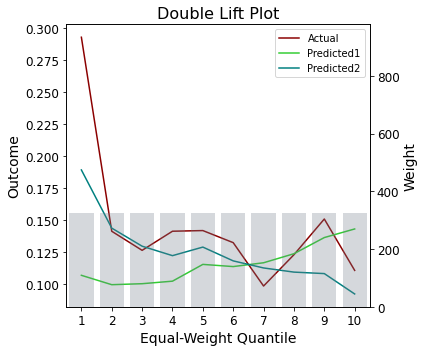

In [21]:
actual = df['actual_y']
weight = df['exposure']
predicted1 = df['pred1']
predicted2 = df['pred2']

fig, ax = plt.subplots(figsize = (6, 5))
double_lift_plot(ax, actual, predicted1, predicted2, weight, quantiles = 10)
plt.show()